#### Energy histograms for dataframes loaded in (BLOB EDITION)

this is exceptionally bespoke

In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

from Tl_studies.functions import isaura_analyse as isa

In [2]:
# read in data
directory = ''
#directory = '../analysis_data/10x10x10_cut_data/'

port_1a = pd.read_hdf(directory + 'P1A_10x10x10.h5')
port_1b = pd.read_hdf(directory + 'P1B_10x10x10.h5')
port_2a = pd.read_hdf(directory + 'P2A_10x10x10.h5')
port_2b = pd.read_hdf(directory + 'P2B_10x10x10.h5')

In [3]:
display(port_1a)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
184,5080188,0,1.596243,137.456298,113,11993,1,156.675,107.675,734.490601,...,789.447427,249.494267,184.766019,738.319437,0.511776,0.245868,0.0,10.000000,9.333333,9.592146
518,5080496,0,1.594183,154.743531,127,12870,1,147.675,-166.325,322.920868,...,348.181738,150.682122,-134.107884,329.234220,0.444847,0.443488,0.0,9.533333,9.200000,8.737142
606,5080582,0,1.595847,134.427703,165,12424,1,293.675,-43.325,683.036133,...,726.958593,344.200068,58.357780,714.376938,0.327431,0.169420,0.0,9.272727,9.615385,8.566711
674,5080676,0,1.594673,123.527479,117,12643,1,185.675,150.675,453.089264,...,466.743201,273.441110,157.500124,496.954274,0.612307,0.345949,0.0,9.416667,10.000000,9.292014
741,1740022,0,1.595029,246.160982,147,12240,1,186.675,-40.325,405.846893,...,498.364705,201.867704,58.954131,414.055713,0.492123,0.414989,0.0,10.000000,9.333333,9.967749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187495,4940584,0,1.598050,118.225238,144,12842,1,299.675,21.675,843.681885,...,909.920034,365.272391,95.558628,847.721470,0.475479,0.155838,0.0,9.100000,9.636364,8.917419
187630,4060092,0,1.611933,139.488392,138,11245,1,147.675,351.675,1015.907898,...,1023.885905,199.399870,392.845961,1111.865537,0.452174,0.263725,0.0,9.454545,9.100000,9.443298
187873,4060350,0,1.594714,193.786162,142,12044,1,43.675,21.675,412.145233,...,443.268241,95.273416,71.054266,541.965957,0.498915,0.433457,0.0,9.769231,9.000000,9.744980
187893,4060374,0,1.604224,110.101848,113,13741,1,231.675,227.675,516.088623,...,540.399202,301.620382,314.980297,538.400907,0.565798,0.366740,0.0,9.625000,9.300000,9.434460


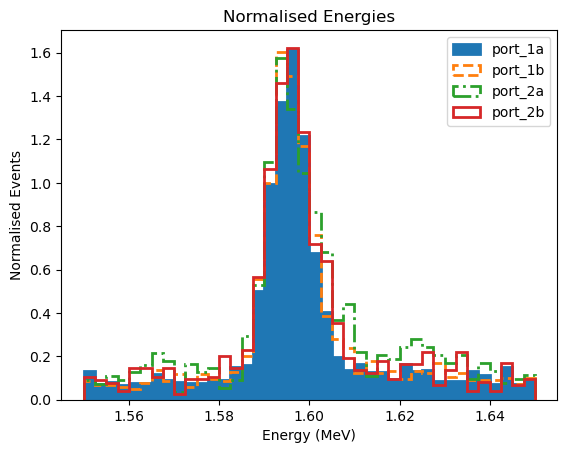

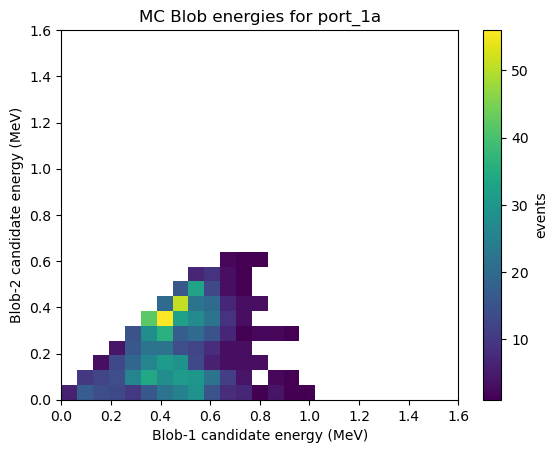

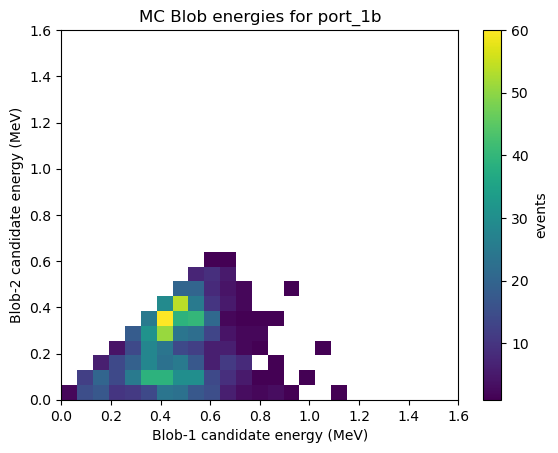

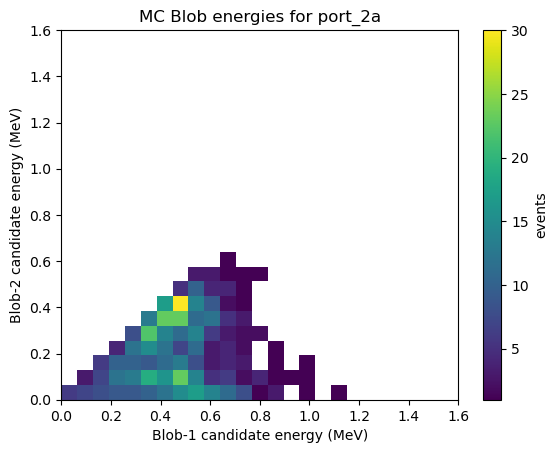

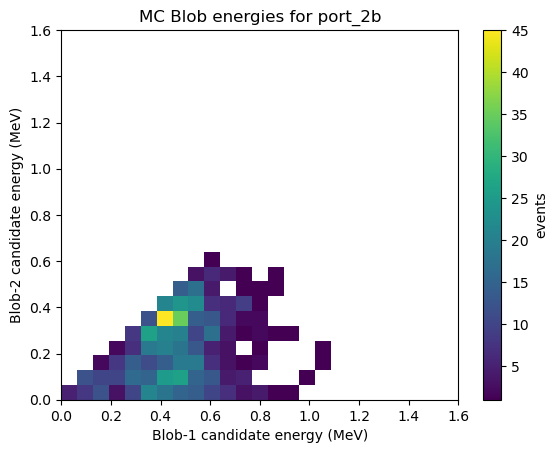

In [4]:
# Scuffed normalisation
list_titles = ['port_1a', 'port_1b', 'port_2a', 'port_2b']

binn = 40
port_Es = []
port_b1 = []
port_b2 = []

fill_style = [True, False, False, False]
lin_style = ['solid', 'dashed', 'dashdot', 'solid']

port_b1.append(port_1a['eblob1'].to_numpy())
port_b1.append(port_1b['eblob1'].to_numpy())
port_b1.append(port_2a['eblob1'].to_numpy())
port_b1.append(port_2b['eblob1'].to_numpy())

port_b2.append(port_1a['eblob2'].to_numpy())
port_b2.append(port_1b['eblob2'].to_numpy())
port_b2.append(port_2a['eblob2'].to_numpy())
port_b2.append(port_2b['eblob2'].to_numpy())


port_Es.append(port_1a['energy'].to_numpy())
port_Es.append(port_1b['energy'].to_numpy())
port_Es.append(port_2a['energy'].to_numpy())
port_Es.append(port_2b['energy'].to_numpy())

for i in range(len(list_titles)):
    hist, bin_edges = np.histogram(port_Es[i], bins = binn)

    # collect weights
    weights = port_Es[i]/np.max(hist)

    # plot with weighting
    plt.hist(port_Es[i], bins = binn, label = list_titles[i], range = (1.55, 1.65), weights = weights, fill = fill_style[i], histtype = 'step', linewidth = 2, linestyle = lin_style[i])

plt.legend()
plt.title("Normalised Energies")
plt.xlabel('Energy (MeV)')
plt.ylabel("Normalised Events")
plt.show()

# plot all the 2d histograms for each port
for i in range(len(list_titles)):
    plt.hist2d(port_b1[i], port_b2[i], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
    plt.colorbar(label='events')
    plt.xlabel("Blob-1 candidate energy (MeV)")
    plt.ylabel("Blob-2 candidate energy (MeV)")
    plt.title("MC Blob energies for {}".format(list_titles[i]))
    plt.show()

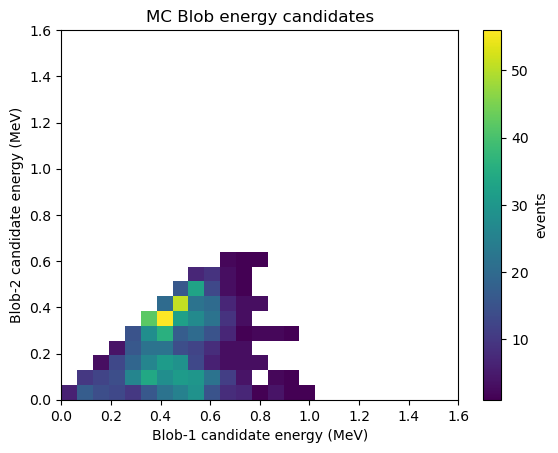

In [5]:
# blob 2dhist
plt.hist2d(port_1a['eblob1'], port_1a['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

### Now lets do the blob_E equivalent

In [6]:
# read in MC events
em, MC_data = isa.load_MC('../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1a/prod/isaura/')

# double the event ids
MC_data['event_id'] = MC_data['event_id'] * 2 


In [ ]:
display(MC_data)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041796,4060712,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.000000,0.000000,0.000000,0.025482,1.436975,eIoni,eIoni
8041797,4060712,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.000000,-0.000000,-0.000000,0.037231,2.202024,eIoni,eIoni
8041798,4060712,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.000000,0.000000,-0.000000,0.016253,0.597368,eIoni,eIoni
8041799,4060712,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.000000,0.000000,-0.000000,0.033170,1.671516,eIoni,eIoni


In [ ]:
display(port_1a)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
184,5080188,0,1.596243,137.456298,113,11993,1,156.675,107.675,734.490601,...,789.447427,249.494267,184.766019,738.319437,0.511776,0.245868,0.0,10.000000,9.333333,9.592146
518,5080496,0,1.594183,154.743531,127,12870,1,147.675,-166.325,322.920868,...,348.181738,150.682122,-134.107884,329.234220,0.444847,0.443488,0.0,9.533333,9.200000,8.737142
606,5080582,0,1.595847,134.427703,165,12424,1,293.675,-43.325,683.036133,...,726.958593,344.200068,58.357780,714.376938,0.327431,0.169420,0.0,9.272727,9.615385,8.566711
674,5080676,0,1.594673,123.527479,117,12643,1,185.675,150.675,453.089264,...,466.743201,273.441110,157.500124,496.954274,0.612307,0.345949,0.0,9.416667,10.000000,9.292014
741,1740022,0,1.595029,246.160982,147,12240,1,186.675,-40.325,405.846893,...,498.364705,201.867704,58.954131,414.055713,0.492123,0.414989,0.0,10.000000,9.333333,9.967749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187495,4940584,0,1.598050,118.225238,144,12842,1,299.675,21.675,843.681885,...,909.920034,365.272391,95.558628,847.721470,0.475479,0.155838,0.0,9.100000,9.636364,8.917419
187630,4060092,0,1.611933,139.488392,138,11245,1,147.675,351.675,1015.907898,...,1023.885905,199.399870,392.845961,1111.865537,0.452174,0.263725,0.0,9.454545,9.100000,9.443298
187873,4060350,0,1.594714,193.786162,142,12044,1,43.675,21.675,412.145233,...,443.268241,95.273416,71.054266,541.965957,0.498915,0.433457,0.0,9.769231,9.000000,9.744980
187893,4060374,0,1.604224,110.101848,113,13741,1,231.675,227.675,516.088623,...,540.399202,301.620382,314.980297,538.400907,0.565798,0.366740,0.0,9.625000,9.300000,9.434460


In [ ]:
# only collect events that match an event in port_1a

In [ ]:
# collect positron events for each port
pos_1a = isa.positron_scraper(MC_data)


In [ ]:
display(pos_1a)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
302,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1182,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
1375,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
1757,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
1829,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037481,4060608,38,e+,False,36,177.461746,373.692688,428.131470,0.812318,178.767731,...,-0.777295,0.036702,-0.102590,0.0,0.0,0.0,0.425579,101.616592,conv,annihil
8038110,4060624,29,e+,False,27,397.566254,407.091736,551.510803,0.072451,397.579163,...,-0.019162,0.906891,1.363706,0.0,0.0,-0.0,1.204703,0.740120,conv,annihil
8040382,4060680,26,e+,False,24,310.088898,408.188171,295.903961,0.852721,310.023529,...,-0.195946,-0.591557,-1.454987,-0.0,-0.0,0.0,1.152263,0.804377,conv,annihil
8041571,4060708,86,e+,False,84,399.468445,406.446594,534.138794,0.026582,399.559052,...,0.388743,0.701915,-0.266944,0.0,-0.0,-0.0,0.477022,0.336314,conv,annihil


In [ ]:
# filter events
nopos_1a_filt = port_1a[~port_1a['event'].isin(pos_1a['event_id'])]
#pos_1a[pos_1a['event_id'].isin(port_1a)]
display(nopos_1a_filt)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
803,1740082,0,1.621295,232.570108,143,11521,1,-9.325,-335.325,191.680923,...,255.239925,67.675000,-163.325000,249.403687,0.457842,0.014532,0.0,9.700000,9.761905,9.968830
2551,1140630,0,1.581736,250.181210,152,12960,1,242.675,-28.325,584.348755,...,673.604405,329.007723,169.294916,592.310692,0.368876,0.093841,0.0,9.400000,9.708333,9.440906
3654,80494,0,1.582480,251.467251,144,11584,1,-171.325,191.675,361.742035,...,415.074954,13.501280,300.826014,399.352786,0.534098,0.060950,0.0,9.843750,9.727273,9.703777
4338,20636,0,1.571437,219.526846,159,11672,1,-9.325,-125.325,337.597870,...,345.600961,78.387606,-6.285645,469.961256,0.495933,0.045397,0.0,9.300000,9.466667,9.520885
4650,3900320,0,1.584964,201.340848,127,9732,1,225.675,287.675,670.439270,...,799.550616,259.457059,360.652292,674.923034,0.546570,0.064789,0.0,9.142857,9.769231,9.612488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185237,4380126,0,1.591507,173.133988,153,10095,1,320.675,-31.325,1036.873047,...,1070.044656,377.702565,109.400752,1126.101920,0.862462,0.052854,0.0,9.454545,9.681818,9.343799
185256,4380146,0,1.551431,233.516531,159,12163,1,-69.325,-328.325,778.565552,...,828.923522,-35.098711,-163.707023,795.814618,0.520701,0.086736,0.0,9.437500,10.000000,9.793315
185489,4380404,0,1.602802,114.254575,133,12561,1,109.675,-121.325,160.171326,...,163.398335,112.684447,-105.738658,208.693340,0.098873,0.092972,0.0,9.533333,9.636364,9.315699
186361,5720068,0,1.627717,267.440167,190,12588,1,-63.325,-95.325,381.729065,...,514.231518,70.155610,23.365667,403.021838,0.475813,0.068553,0.0,10.000000,9.615385,9.741394


Text(0.5, 1.0, 'Port 1a blob energy histograms (with background)')

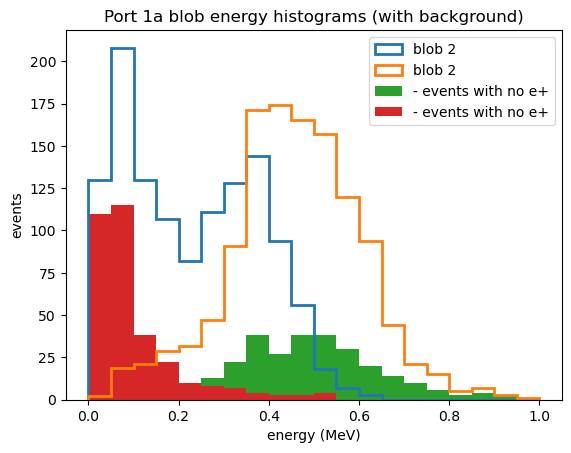

In [ ]:
these_bins = 20

isa.plot_hist(port_1a, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (0, 1))
isa.plot_hist(port_1a, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (0, 1))


isa.plot_hist(nopos_1a_filt, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (0, 1))
isa.plot_hist(nopos_1a_filt, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (0, 1))

plt.legend()
plt.title('Port 1a blob energy histograms (with background)')

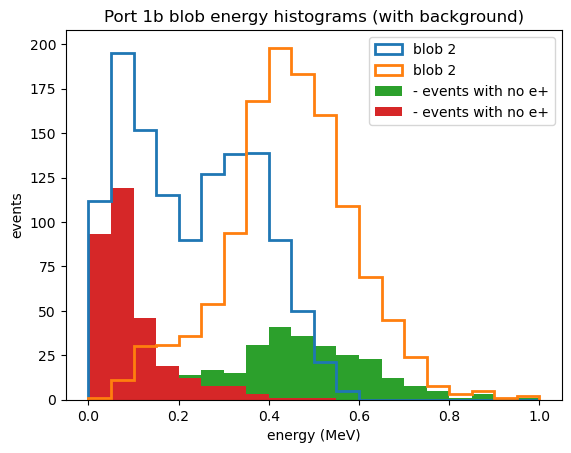

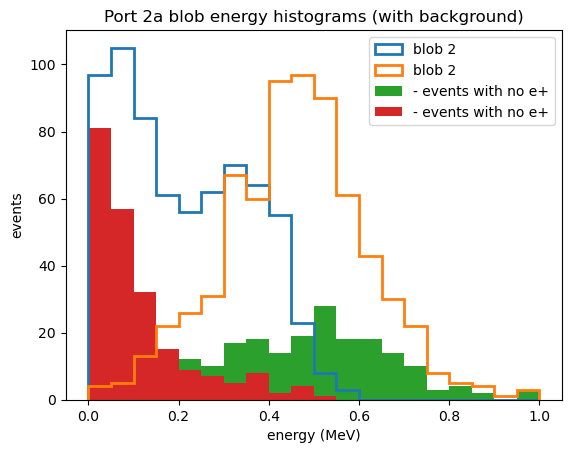

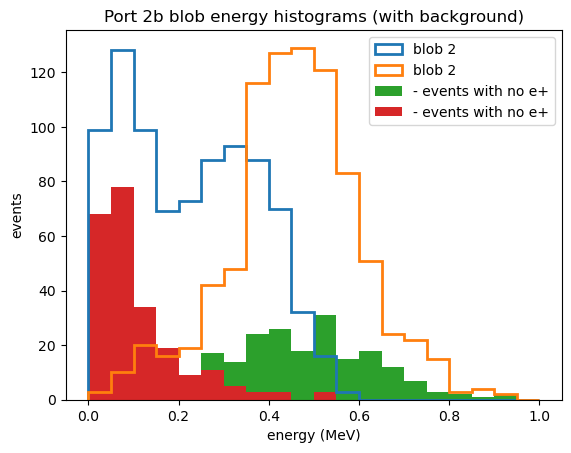

In [ ]:
# define a loop for plotting the 2d histograms for each port

data_mc = ['../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1b/prod/isaura/',
           '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2a/prod/isaura/',
           '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2b/prod/isaura/']

titles = ['Port 1b', 'Port 2a', 'Port 2b']

data_ports = [port_1b, port_2a, port_2b]


for i in range(len(data_mc)):
    
    # read in MC events
    em, MC_data = isa.load_MC(data_mc[i])

    # double the event ids
    MC_data['event_id'] = MC_data['event_id'] * 2 

    # collect positron events for each port
    pos = isa.positron_scraper(MC_data)

    # filter events
    nopos = data_ports[i][~data_ports[i]['event'].isin(pos['event_id'])]

    these_bins = 20

    isa.plot_hist(data_ports[i], column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (0, 1))
    isa.plot_hist(data_ports[i], column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (0, 1))


    isa.plot_hist(nopos, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (0, 1))
    isa.plot_hist(nopos, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (0, 1))

    plt.legend()
    plt.title('{} blob energy histograms (with background)'.format(titles[i]))
    plt.show()

    del em
    del MC_data
    del pos
    del nopos